In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *

In [4]:
bs = 64

In [5]:
path = untar_data(URLs.PETS)/'images'

In [6]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4, 
                     p_affine=1., p_lighting=1.)

In [7]:
doc(get_transforms)

In [8]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [9]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
            .transform(tfms, size=size, padding_mode=padding_mode)
            .databunch(bs=bs).normalize(imagenet_stats))

In [10]:
data = get_data(224, bs, 'zeros')

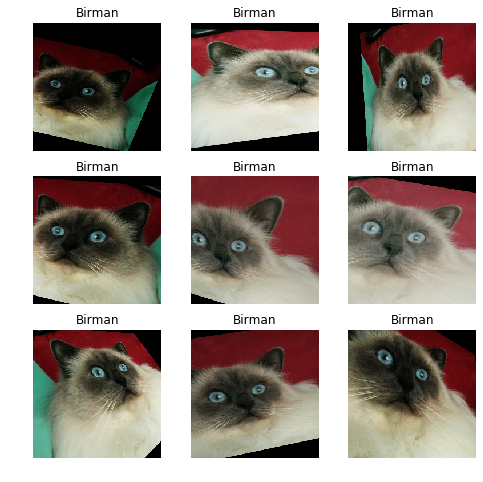

In [12]:
def _plot(i, j, ax):
    x, y = data.train_ds[33]
    x.show(ax, y=y)
    
plot_multi(_plot, 3, 3, figsize=(8, 8))

In [13]:
data = get_data(224, bs)

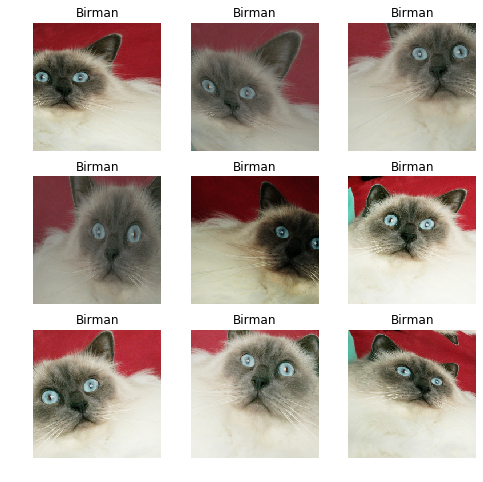

In [14]:
plot_multi(_plot, 3, 3, figsize=(8, 8))